# Italian Word Lemmatizer

### Import


In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
from keras import backend as K
from keras.layers import Input, LSTM, Dense, Embedding, Concatenate, Bidirectional, TimeDistributed, RepeatVector, Activation, Dot, Lambda, Dropout, Add, Multiply, Masking, Attention
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import numpy as np
import gensim
import tensorflow as tf
import pandas as pd
import datetime
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# set all random seeds
np.random.seed(42)
tf.random.set_seed(42)


## Dataset

In [28]:

dataset_path = "./dev.csv"
df_dev = pd.read_csv(dataset_path, sep="\t", header=None,
                     names=["word", "tag", "lemm"])

dataset_path = "./test.csv"
df_test = pd.read_csv(dataset_path, sep="\t", header=None,
                      names=["word", "tag", "lemm"])

df_dev["word"] = df_dev["word"].astype(str)
df_dev["tag"] = df_dev["tag"].astype(str)
df_dev["lemm"] = df_dev["lemm"].astype(str)

df_test["word"] = df_test["word"].astype(str)
df_test["tag"] = df_test["tag"].astype(str)
df_test["lemm"] = df_test["lemm"].astype(str)

# remove head
df_dev = df_dev.iloc[1:]
df_test = df_test.iloc[1:]

# lower case all words
df_test["word"] = df_test["word"].str.lower()
df_dev["word"] = df_dev["word"].str.lower()

def get_sentences(df):
    words = []
    tags = []
    lemmas = []
    sentence = []
    max_s = 0
    for index, row in df.iterrows():
        word = row["word"]
        tag = row["tag"]
        lemm = row["lemm"]
        sentence.append([word, tag, lemm])

        if row["word"] in [".", "?", "!", ";"]:
            words.append([word for word, tag, lemm in sentence])
            tags.append([tag for word, tag, lemm in sentence])
            lemmas.append([lemm for word, tag, lemm in sentence])
            max_s = max(max_s, len(sentence))
            sentence = []

    print("Max sentence length: ", max_s)
    return words, tags, lemmas

# _s is for string
dev_words_s, dev_tags_s, dev_lemmas_s = get_sentences(df_dev)
test_words_s, test_tags_s, test_lemmas_s = get_sentences(df_test)
print("Number of sentences in dev set: ", len(dev_words_s))
print("Number of sentences in test set: ", len(test_words_s))

# print number of unique tags
print("Number of unique tags: ", len(df_dev["tag"].unique()))

for i in range(len(dev_words_s)):
    if len(dev_words_s[i]) != len(dev_tags_s[i]) or len(dev_words_s[i]) != len(dev_lemmas_s[i]):
        print("Dimension mismatch in sentence: ", i)
        print("Words: ", dev_words_s[i])
        print("Tags: ", dev_tags_s[i])
        print("Lemmas: ", dev_lemmas_s[i])
        break

Max sentence length:  95
Max sentence length:  107
Number of sentences in dev set:  703
Number of sentences in test set:  5596
Number of unique tags:  32


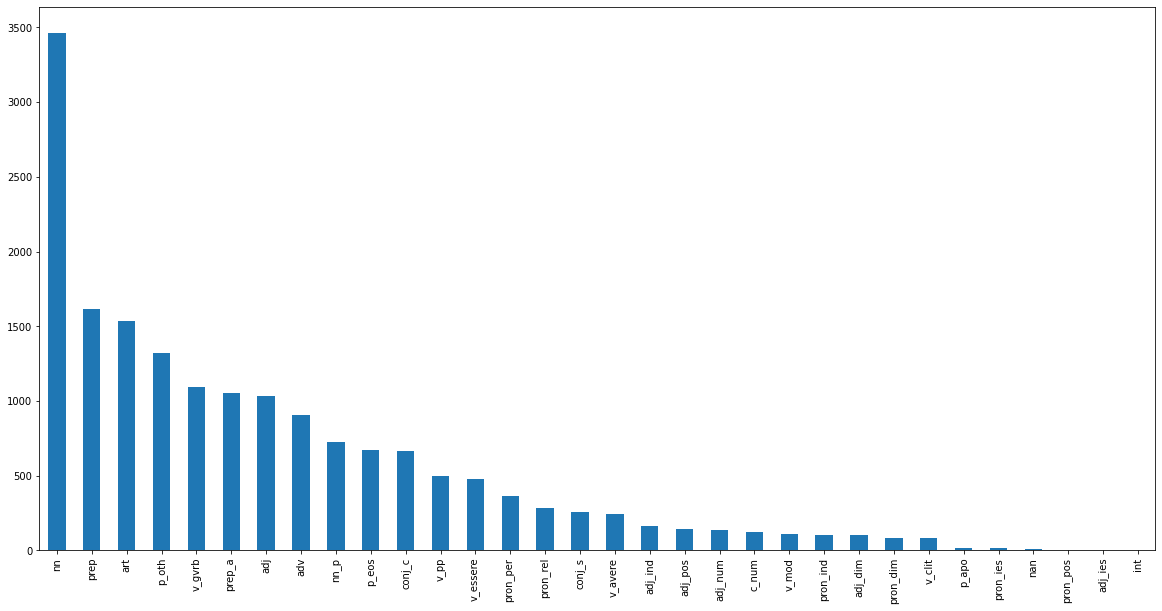

In [29]:
# plot tag distribution
tags = []
for tag_list in dev_tags_s:
    tags.extend(tag_list)

tags = pd.Series(tags)
tags.value_counts().plot(kind="bar", figsize=(20, 10))
plt.show()

## Word Context

In [30]:
CTX_DIM = 12            # context dimension, 12 words on each side
PRE_VALUE = "<PRE>"     # value for padding pre 
POST_VALUE = "<POST>"   # value for padding post
NONE_TAG = "<NONE>"     # value for padding tags

def get_context(words, tags, lemmas):
    ctx = []    # context list
    w = []      # word list
    tag = []    # context tags list
    t = []      # word tags list
    lemma = []  # lemma list

    for s_index in range(len(words)):
        s = words[s_index]
        s_tags = tags[s_index]
        sentence = " ".join(s)
        s = [PRE_VALUE] * CTX_DIM + s + [POST_VALUE] * CTX_DIM
        s_tags = [NONE_TAG] * CTX_DIM + s_tags + [NONE_TAG] * CTX_DIM

        for w_index in range(len(s)):
            if w_index < CTX_DIM or w_index >= len(s) - CTX_DIM:
                continue

            context = s[w_index - CTX_DIM:w_index] + [s[w_index]] +s[w_index + 1:w_index  + CTX_DIM + 1]
            context = " ".join(context)
            ctx.append(context)
            w.append(words[s_index][w_index-CTX_DIM])

            ctx_tags = s_tags[w_index - CTX_DIM:w_index] + [s_tags[w_index]] + s_tags[w_index + 1:w_index  + CTX_DIM + 1]
            tag.append(ctx_tags)
            t.append(tags[s_index][w_index-CTX_DIM])

            lemma.append(lemmas[s_index][w_index-CTX_DIM])
    return ctx, w, tag, t, lemma

dev_ctx, dev_words, dev_tags, dev_tag,dev_lemmas = get_context(dev_words_s, dev_tags_s, dev_lemmas_s)
test_ctx, test_words, test_tags, test_tag,test_lemmas = get_context(test_words_s, test_tags_s, test_lemmas_s)

dev_ctx, val_ctx, dev_words, val_words, dev_tags, val_tags, dev_tag, val_tag, dev_lemmas, val_lemmas = train_test_split(dev_ctx, dev_words, dev_tags, dev_tag, dev_lemmas, test_size=0.05, random_state=42)

print("Number of sample in dev set: ", len(dev_lemmas))
print("Number of sample in val set: ", len(val_lemmas))
print("Number of sample in test set: ", len(test_lemmas))

Number of sample in dev set:  16447
Number of sample in val set:  866
Number of sample in test set:  133756


### Example of context

In [31]:
print("CTX Dim:", CTX_DIM, "\n")
for i in range(3):
    index = np.random.randint(0, len(dev_ctx))
    print("CTX: ", dev_ctx[index])
    print("CTX Tags: ", dev_tags[index])
    print("Word: ", dev_words[index])
    print("Tag: ", dev_tag[index])
    print("Lemma: ", dev_lemmas[index])
    print()


CTX Dim: 12 

CTX:  <PRE> ma i blair , con i ragazzi da distrarre , avevano altre idee . <POST> <POST> <POST> <POST> <POST> <POST> <POST> <POST> <POST> <POST>
CTX Tags:  ['<NONE>', 'conj_c', 'art', 'nn_p', 'p_oth', 'prep', 'art', 'nn', 'prep', 'v_gvrb', 'p_oth', 'v_avere', 'adj_ind', 'nn', 'p_eos', '<NONE>', '<NONE>', '<NONE>', '<NONE>', '<NONE>', '<NONE>', '<NONE>', '<NONE>', '<NONE>', '<NONE>']
Word:  altre
Tag:  adj_ind
Lemma:  altro

CTX:  rigorosamente accademico , corredata da una ricca e del tutto inverosimile bibliografia e arricchita da numerose tavole iconografiche , &egrave; stata recentemente pubblicata anche in
CTX Tags:  ['adv', 'adj', 'p_oth', 'v_pp', 'prep', 'art', 'adj', 'conj_c', 'prep_a', 'nn', 'adj', 'nn', 'conj_c', 'v_pp', 'prep', 'adj', 'nn', 'adj', 'p_oth', 'v_essere', 'v_essere', 'adv', 'v_pp', 'conj_c', 'prep']
Word:  e
Tag:  conj_c
Lemma:  e

CTX:  * difesa dei diritti dei curdi l' italia porter&agrave; davanti_ai fori internazionali la questione dei diritti d

## Open Class Words
The evaluation is done only on open-class words and not to functional words: only the tokens having a PoS-tag comprised in the set ADJ *, ADV, NN, V * had to be lemmatised, in all the other cases the token could be copied unchanged into the lemma column as they were not considered for the evaluation (the asterisk indicates all PoS-tag possibilities beginning with that prefix).

In [32]:
def get_open_class_words(ctx, words, tags, tag, lemmas):
    open_class_words = []   # open class words
    open_class_ctx = []     # open class context 
    open_class_tags = []    # open class tags
    open_class_tag = []     # open class tag
    open_class_lemmas = []  # open class lemmas

    open_classes = ["nn", "v_gvrb", "v_essere", "v_avere", "v_pp", "v_mod", "v_clit", "adv", "adj_ind", "adj_num", "adj", "adj_pos", "adj_dim", "adj_ies"]

    for i in range(len(words)):
        t = tag[i]
        if t in open_classes:
            open_class_words.append(words[i])
            open_class_ctx.append(ctx[i])
            open_class_tags.append(tags[i])
            open_class_tag.append(t)
            open_class_lemmas.append(lemmas[i])

    return open_class_ctx, open_class_words, open_class_tags, open_class_tag, open_class_lemmas


test_ctx, test_words, test_tags, test_tag, test_lemmas = get_open_class_words(test_ctx, test_words, test_tags, test_tag, test_lemmas)
dev_ctx, dev_words, dev_tags, dev_tag, dev_lemmas = get_open_class_words(dev_ctx, dev_words, dev_tags, dev_tag, dev_lemmas)
val_ctx, val_words, val_tags, val_tag, val_lemmas = get_open_class_words(val_ctx, val_words, val_tags, val_tag, val_lemmas)

print("Number of open class words in dev set: ", len(dev_words))
print("Number of open class words in val set: ", len(val_words)) 
print("Number of open class words in test set: ", len(test_words))  
# total 79984

Number of open class words in dev set:  8045
Number of open class words in val set:  421
Number of open class words in test set:  65210


## Encoding

In [7]:
# word encoder
word_tokenizer = Tokenizer(filters="")
word_tokenizer.fit_on_texts(dev_ctx + test_ctx + val_ctx)

# tag encoder
tag_tokenizer = Tokenizer(filters="")
tag_tokenizer.fit_on_texts(dev_tags + test_tags + val_tags)

# lemma encoder
lemma_tokenizer = Tokenizer(filters="")
lemma_tokenizer.fit_on_texts(dev_lemmas_s + test_lemmas_s)

dev_ctx_e = word_tokenizer.texts_to_sequences(dev_ctx)
val_ctx_e = word_tokenizer.texts_to_sequences(val_ctx)
test_ctx_e = word_tokenizer.texts_to_sequences(test_ctx)

dev_tags_e = tag_tokenizer.texts_to_sequences(dev_tags)
val_tags_e = tag_tokenizer.texts_to_sequences(val_tags)
test_tags_e = tag_tokenizer.texts_to_sequences(test_tags)


# get all unique letter in words
characters = set()

MAX_WORD_LENGTH = 0

for w in dev_words + test_words + dev_lemmas + test_lemmas + val_words + val_lemmas:
    MAX_WORD_LENGTH = max(MAX_WORD_LENGTH, len(w))

    for letter in w:
        characters.add(letter)

# add padding and unknown to characters
characters.add(" ")

# the length of the vocab for one-hot encoded char
VOCAB_SIZE = len(characters)

print ("Vocab size: ", VOCAB_SIZE)
print("Max word length: ", MAX_WORD_LENGTH)

characters = sorted(list(characters))

char2idx = {char: idx for idx, char in enumerate(characters)}
idx2char = {idx: char for idx, char in enumerate(characters)}

def encode_words(words):
    encoded_words = []
    for word in words:
        word_e = []
        for letter in word:
            word_e.append(characters.index(letter))
        encoded_words.append(word_e)
    return encoded_words

dev_words_e = encode_words(dev_words)
test_words_e = encode_words(test_words)
val_words_e = encode_words(val_words)

dev_lemmas_e = encode_words(dev_lemmas)
test_lemmas_e = encode_words(test_lemmas)
val_lemmas_e = encode_words(val_lemmas)

dev_words_e = tf.keras.preprocessing.sequence.pad_sequences(dev_words_e, maxlen=MAX_WORD_LENGTH, padding="post")
test_words_e = tf.keras.preprocessing.sequence.pad_sequences(test_words_e, maxlen=MAX_WORD_LENGTH, padding="post")
val_words_e = tf.keras.preprocessing.sequence.pad_sequences(val_words_e, maxlen=MAX_WORD_LENGTH, padding="post")

dev_lemmas_e = tf.keras.preprocessing.sequence.pad_sequences(dev_lemmas_e, maxlen=MAX_WORD_LENGTH, padding="post")
test_lemmas_e = tf.keras.preprocessing.sequence.pad_sequences(test_lemmas_e, maxlen=MAX_WORD_LENGTH, padding="post")
val_lemmas_e = tf.keras.preprocessing.sequence.pad_sequences(val_lemmas_e, maxlen=MAX_WORD_LENGTH, padding="post")

index = np.random.randint(0, len(dev_ctx))
print("\nContext: \n", dev_ctx[index], "\n", dev_ctx_e[index])
print("\nTags: \n", dev_tags[index], "\n", dev_tags_e[index])
print("\nWords: \n", dev_words[index], "\n", dev_words_e[index])
print("\nLemma: \n", dev_lemmas[index], "\n", dev_lemmas_e[index])


Vocab size:  41
Max word length:  25

Context: 
 , l' unico espediente a disposizione &egrave; l' appropriato uso di esplosioni nucleari . <POST> <POST> <POST> <POST> <POST> <POST> <POST> <POST> <POST> <POST> <POST> 
 [3, 19, 471, 11863, 10, 580, 13, 19, 4975, 424, 4, 6870, 4664, 6, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

Tags: 
 ['p_oth', 'art', 'adj', 'nn', 'prep', 'nn', 'v_essere', 'art', 'adj', 'nn', 'prep', 'nn', 'adj', 'p_eos', '<NONE>', '<NONE>', '<NONE>', '<NONE>', '<NONE>', '<NONE>', '<NONE>', '<NONE>', '<NONE>', '<NONE>', '<NONE>'] 
 [5, 4, 6, 2, 3, 2, 13, 4, 6, 2, 3, 2, 6, 14, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

Words: 
 nucleari 
 [28 35 17 26 19 15 32 23  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0]

Lemma: 
 nucleare 
 [28 35 17 26 19 15 32 19  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0]


In [8]:
# one hot encode the characters for the lemmas
dev_lemmas_e = tf.one_hot(dev_lemmas_e, VOCAB_SIZE)
test_lemmas_e = tf.one_hot(test_lemmas_e, VOCAB_SIZE)
val_lemmas_e = tf.one_hot(val_lemmas_e, VOCAB_SIZE)

In [9]:
# trnasform to numpy array
dev_ctx_e = np.array(dev_ctx_e)
dev_words_e = np.array(dev_words_e)
dev_tags_e = np.array(dev_tags_e)
dev_lemmas_e = np.array(dev_lemmas_e)

test_ctx_e = np.array(test_ctx_e)
test_words_e = np.array(test_words_e)
test_tags_e = np.array(test_tags_e)
test_lemmas_e = np.array(test_lemmas_e)

val_ctx_e = np.array(val_ctx_e)
val_words_e = np.array(val_words_e)
val_tags_e = np.array(val_tags_e)
val_lemmas_e = np.array(val_lemmas_e)

print("Train shape")
print("Context shape: ", dev_ctx_e.shape)
print("Words shape: ", dev_words_e.shape)
print("Tags shape: ", dev_tags_e.shape)
print("Lemmas shape: ", dev_lemmas_e.shape)

print("\nTest shape")
print("Context shape: ", test_ctx_e.shape)
print("Words shape: ", test_words_e.shape)
print("Tags shape: ", test_tags_e.shape)
print("Lemmas shape: ", test_lemmas_e.shape)

Train shape
Context shape:  (8045, 25)
Words shape:  (8045, 25)
Tags shape:  (8045, 25)
Lemmas shape:  (8045, 25, 41)

Test shape
Context shape:  (65210, 25)
Words shape:  (65210, 25)
Tags shape:  (65210, 25)
Lemmas shape:  (65210, 25, 41)


## Model

### Lemmatization Accuracy

In [10]:
def accuracy(y_true, y_pred):
    y_true = tf.argmax(y_true, axis=-1)
    y_pred = tf.argmax(y_pred, axis=-1)
    correct_predictions = tf.reduce_all(tf.equal(y_true, y_pred), axis=-1)
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
    return accuracy


### Word2Vec

In [11]:
EMBEDDING_DIM = 384
VOCABULARY_SIZE = len(word_tokenizer.word_index) + 1

def get_word2vec_weights(DIM):
    # train word2vec model
    word2vec = gensim.models.Word2Vec(dev_words + test_words_s, size=DIM, window=10, min_count=1, workers=8)

    # create an empty embedding matix
    embedding_weights = np.zeros((VOCABULARY_SIZE, DIM))

    # create a word to index dictionary mapping
    word2id = word_tokenizer.word_index

    # copy vectors from word2vec model to the words present in corpus
    for word, index in word2id.items():
        try:
            embedding_weights[index, :] = word2vec.wv[word]
        except KeyError:
            pass

    return embedding_weights

embedding_weights = get_word2vec_weights(EMBEDDING_DIM)

In [23]:
# Neural network model
# inputs:
#   - context: (batch_size, CTX_DIM * 2) 
#   - tags: encoded tags: (batch_size, MAX_WORD_LENGTH)
#   - words: encoded words: (batch_size, MAX_WORD_LENGTH)
# outputs:
#  - lemma: encoded lemma: (batch_size, MAX_WORD_LENGTH)

def get_model():
    # context
    context_input = Input(shape=(CTX_DIM * 2 + 1,), name="context_input")
    context_input = Masking(mask_value=1)(context_input)
    context_input = Masking(mask_value=2)(context_input)
    context_embedding = Embedding(len(word_tokenizer.word_index) + 1, EMBEDDING_DIM, input_length=CTX_DIM * 2 + 1,name="context_embedding", trainable=False, weights=[embedding_weights])(context_input)
    context_embedding = Bidirectional(LSTM(EMBEDDING_DIM, return_sequences=True))(context_embedding)

    # tags
    tags_input = Input(shape=(CTX_DIM * 2 + 1,), name="tags_input")
    tags_input = Masking(mask_value=1)(tags_input)
    tags_embedding = Embedding(len(tag_tokenizer.word_index) + 1, 64, input_length=CTX_DIM * 2 + 1, name="tags_embedding", trainable=True)(tags_input)
    tags_embedding = Bidirectional(LSTM(64, return_sequences=True))(tags_embedding)
    tags_embedding = TimeDistributed(Dense(EMBEDDING_DIM*2))(tags_embedding)
    
    # words
    words_input = Input(shape=(MAX_WORD_LENGTH,), name="words_input")
    words_input = Masking(mask_value=0)(words_input)
    words_embedding = Embedding(VOCAB_SIZE, 64, input_length=MAX_WORD_LENGTH, name="words_embedding", trainable=True)(words_input)
    words_embedding = Bidirectional(LSTM(EMBEDDING_DIM, return_sequences=True))(words_embedding)

    # combine
    attention = Attention(name="attention")([context_embedding, tags_embedding])
    combine = Concatenate(axis=-1)([attention, words_embedding])
    
    lstm = Bidirectional(LSTM(EMBEDDING_DIM, return_sequences=True), name="lstm")(combine)
    lstm = Dropout(0.5)(lstm)
    lstm = Bidirectional(LSTM(EMBEDDING_DIM, return_sequences=True), name="lstm2")(lstm)

    dense = TimeDistributed(Dense(EMBEDDING_DIM, activation="relu", name="dense"))(lstm)
    dense = Dropout(0.3)(dense)
    dense = TimeDistributed(Dense(EMBEDDING_DIM, activation="relu", name="dense"))(dense)
    dense = Dropout(0.2)(dense)
    dense = TimeDistributed(Dense(EMBEDDING_DIM, activation="relu", name="dense"))(dense)
    dense = Dropout(0.2)(dense)
    dense = TimeDistributed(Dense(EMBEDDING_DIM, activation="relu", name="dense"))(dense)

    output = TimeDistributed(Dense(VOCAB_SIZE, activation="softmax"), name="output")(dense)
    return Model(inputs=[context_input, tags_input, words_input], outputs=[output])

model = get_model()
model.summary()


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 25)]         0           []                               
                                                                                                  
 input_13 (InputLayer)          [(None, 25)]         0           []                               
                                                                                                  
 tags_embedding (Embedding)     (None, 25, 64)       2176        ['input_14[0][0]']               
                                                                                                  
 context_embedding (Embedding)  (None, 25, 384)      7593216     ['input_13[0][0]']               
                                                                                            

### Training

In [24]:
early_stopping = EarlyStopping(monitor="val_accuracy", patience=25, restore_best_weights=True)


model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=[accuracy])

# train model
history = model.fit([dev_ctx_e, dev_tags_e, dev_words_e], dev_lemmas_e, epochs=100, batch_size=64, validation_data=([val_ctx_e, val_tags_e, val_words_e], val_lemmas_e), callbacks=[early_stopping])

Epoch 1/100
126/126 [==============================] - 22s 60ms/step - loss: 0.9230 - accuracy: 0.0000e+00 - val_loss: 0.7636 - val_accuracy: 0.0000e+00
Epoch 2/100
126/126 [==============================] - 4s 33ms/step - loss: 0.7551 - accuracy: 1.2401e-04 - val_loss: 0.6514 - val_accuracy: 0.0000e+00
Epoch 3/100
126/126 [==============================] - 4s 34ms/step - loss: 0.3790 - accuracy: 0.1494 - val_loss: 0.1870 - val_accuracy: 0.4879
Epoch 4/100
126/126 [==============================] - 4s 33ms/step - loss: 0.1785 - accuracy: 0.4536 - val_loss: 0.1523 - val_accuracy: 0.5381
Epoch 5/100
126/126 [==============================] - 4s 34ms/step - loss: 0.1458 - accuracy: 0.5085 - val_loss: 0.1252 - val_accuracy: 0.5614
Epoch 6/100
126/126 [==============================] - 4s 33ms/step - loss: 0.1266 - accuracy: 0.5226 - val_loss: 0.1058 - val_accuracy: 0.5799
Epoch 7/100
126/126 [==============================] - 4s 33ms/step - loss: 0.1007 - accuracy: 0.5782 - val_loss: 0.091

## Evaluation

In [26]:
# evaluate model
result = model.evaluate([test_ctx_e, test_tags_e, test_words_e], test_lemmas_e)
print("Test loss: ", result[0])
print("Test accuracy: ", result[1])

2038/2038 [==============================] - 25s 12ms/step - loss: 0.0323 - accuracy: 0.9507
Test loss:  0.0322524830698967
Test accuracy:  0.9507447481155396


In [33]:
# Absolute error with respect to the PoS tag

pred = model.predict([test_ctx_e, test_tags_e, test_words_e])

tot_error = 0
error_per_tag = {}
tag_count = {}

for i in range(len(test_lemmas_e)): 
    tag = test_tag[i].split("_")[0]

    if tag not in tag_count:
            tag_count[tag] = 1
    else:
        tag_count[tag] += 1

    if test_lemmas_e[i].argmax() != pred[i].argmax():
        tot_error += 1
        
        if tag not in error_per_tag:
            error_per_tag[tag] = 1
        else:
            error_per_tag[tag] += 1

print("Absolute error with respect to the PoS tag: ")
for tag in error_per_tag:
    print(tag, round(error_per_tag[tag] / tot_error,3))

print("\nRelative error with respect to the PoS tag: ")
for tag in error_per_tag:
    print(tag, round(error_per_tag[tag] / tag_count[tag], 3))

2038/2038 [==============================] - 28s 12ms/step
Absolute error with respect to the PoS tag: 
v 0.531
adj 0.128
nn 0.297
adv 0.045

Relative error with respect to the PoS tag: 
v 0.083
adj 0.031
nn 0.034
adv 0.02
